In [1]:
file_path = "../../../testdata/test2.nd2"
output_dir = "../../../testdata/test2_output"
metadata_path : str = "../../../testdata/test2_output/test2_metadata.yaml"
profile_filename = "shading_profile.zarr"

strategy = "timewise" 
robust = False
num_cpus=10
median_filter_size = 3
gaussian_filter_size = 25

In [2]:
assert strategy in ["timewise"], "strategy must be 'timewise'"
assert isinstance(robust, bool), "robust must be a boolean"

In [3]:
from pathlib import Path

def to_path(x):
    return Path(x).absolute()

_file_path = to_path(file_path)
_output_dir = to_path(output_dir)
_metadata_path = to_path(metadata_path)

# Import packages and define functions

In [4]:
from aicsimageio import AICSImage
from matplotlib import pyplot as plt
import numpy as np
import yaml
from utils import read_mosaic_image, open_zarr_with_synchronizer
from common import estimate_median_profile
from joblib import Parallel, delayed

/home/fukai/.pyenv/versions/miniforge3-latest/envs/microflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-20 22:53:56,686	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
metadata = yaml.safe_load(Path(_metadata_path).read_text())
channel_names = metadata["channel_names"]
mosaic_dim = metadata["mosaic_dim"]
print(channel_names, mosaic_dim)

['10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS', '10x_Fukai_mCherry_IS', '10x_Fukai_EGFP_IS'] scene


# Shading correction

## Open images 

In [6]:
aics_image = AICSImage(_file_path,reconstruct_mosaic=False) 
image = read_mosaic_image(aics_image, mosaic_dim, "TCZYX")

In [7]:
image.shape # (M, T, C, Z, Y, X)

(48, 2, 4, 1, 2296, 2656)

## Output files

In [8]:
profile_path = _output_dir/profile_filename
chunks = [1] * len(image.shape[:-2]) + list(image.shape[-2:])
profile_zarr = open_zarr_with_synchronizer(profile_path,
                         shape=[1]+list(image.shape[1:]),#TCZYX
                         dtype=np.float32,
                         chunks = chunks
                         #compressor=Zstd(level=2)
                         )

# Estimate shading

In [9]:
def process_image(profile_zarr, image, t, c):
    profile_zarr[0,t,c, ... ] = estimate_median_profile(image[:,t,c,...], 0, robust=robust, keepdims=False, median_filter_size=median_filter_size, gaussian_filter_size=gaussian_filter_size)

with Parallel(n_jobs=num_cpus) as parallel:
    parallel(delayed(process_image)(profile_zarr, image, t, c) for t, c in np.ndindex(image.shape[1:3]))

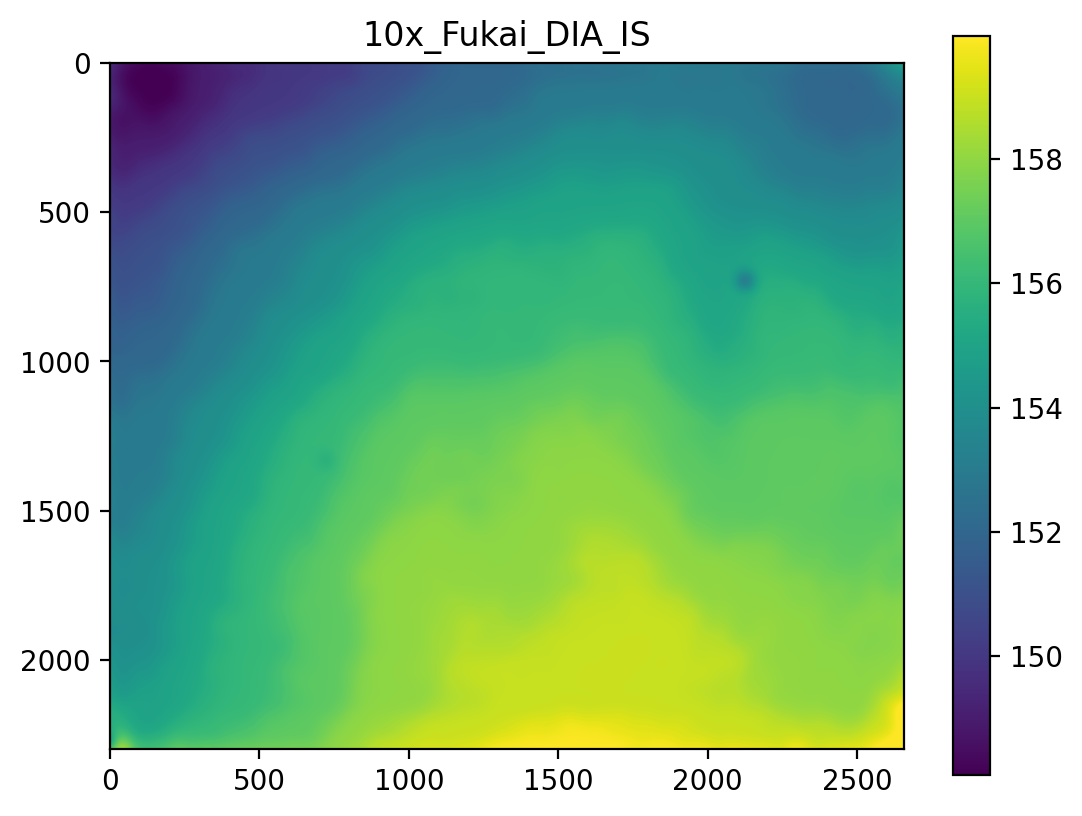

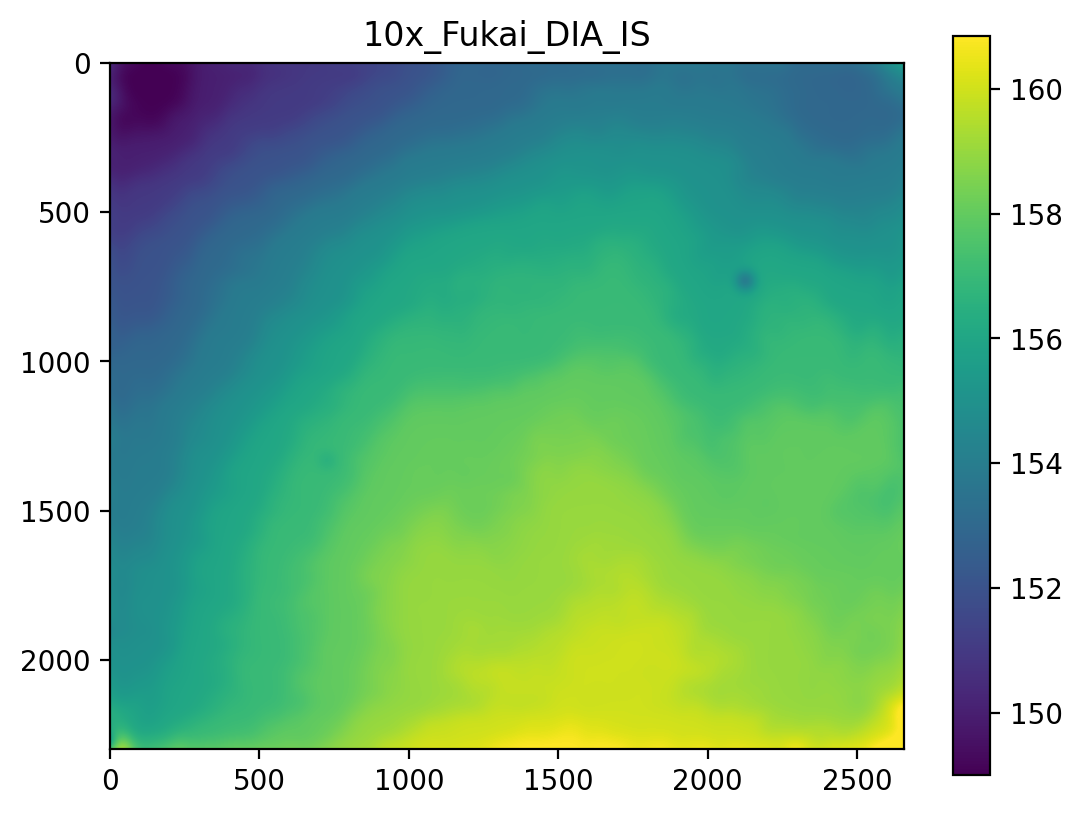

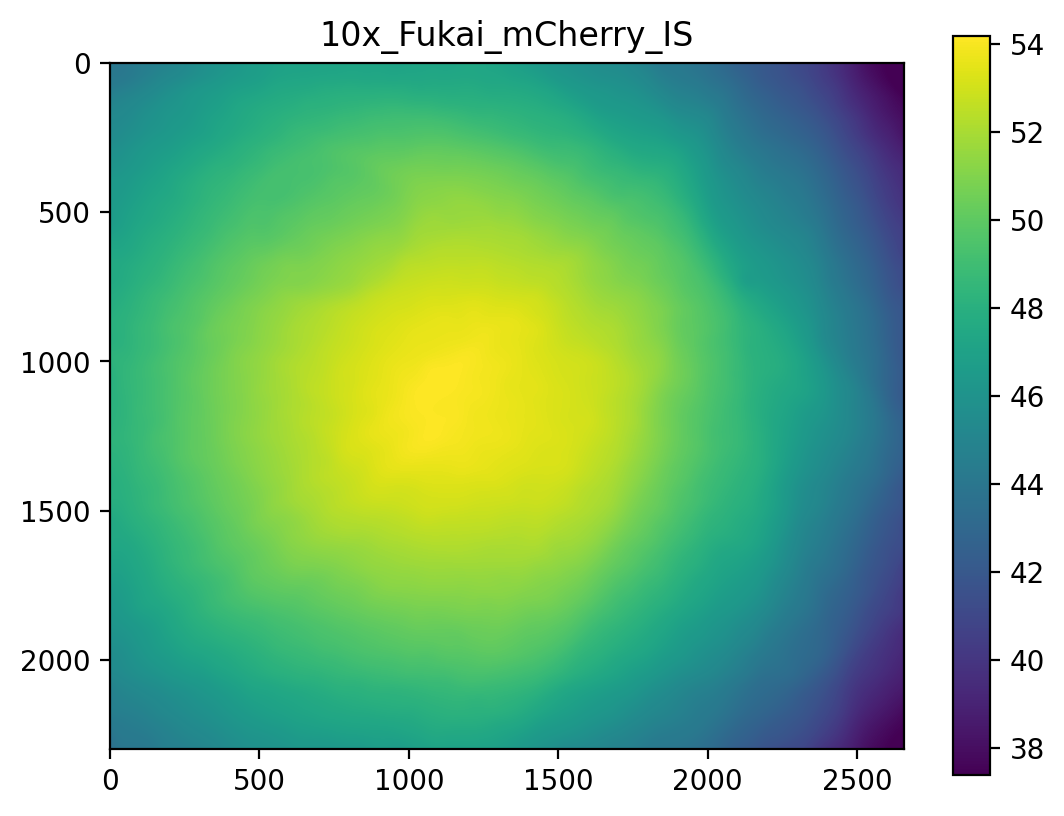

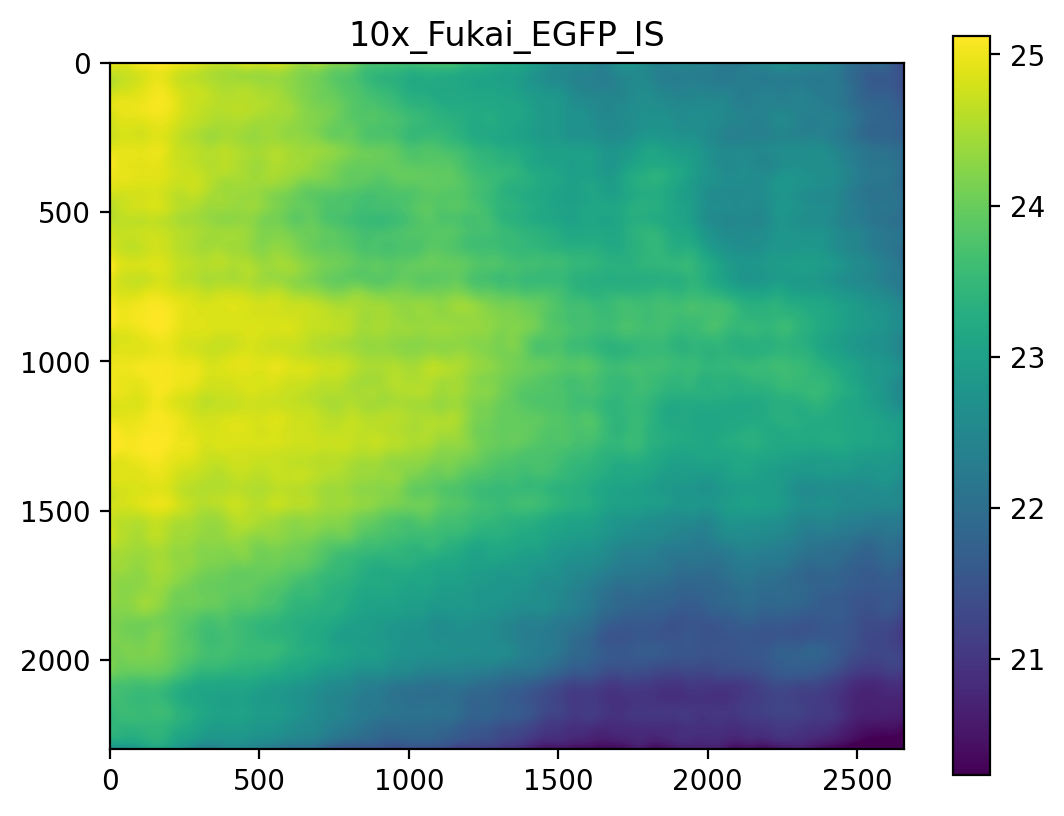

In [10]:
channel_names = channel_names
for j, Cn in enumerate(channel_names):
    m, M = np.percentile(profile_zarr[0,0,j], (0.1, 99.9))
    plt.imshow(profile_zarr[0,0,j,0], vmin=m, vmax=M)
    plt.title(Cn)
    plt.colorbar()
    plt.show()